In [164]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [165]:
df_weekly_sum = pd.read_csv('dpgr_who_countries_1.csv')
df_weekly_sum.head()

,Variant,Date,Location,Freq
0,Alpha,2019-12-30/2020-01-05,Africa / South Africa / Gauteng,1
1,Alpha,2019-12-30/2020-01-05,Asia / India / Kerala,5
2,Alpha,2019-12-30/2020-01-05,Asia / India / Tamil Nadu,1
3,Alpha,2019-12-30/2020-01-05,Austria,4
4,Alpha,2019-12-30/2020-01-05,Europe / Cyprus,21


In [166]:
 df_weekly_sum[df_weekly_sum['Location'] == 'Turkey']

,Variant,Date,Location,Freq
323,Alpha,2020-12-21/2020-12-27,Turkey,3
504,Alpha,2020-12-28/2021-01-03,Turkey,12
639,Alpha,2021-01-04/2021-01-10,Turkey,8
766,Alpha,2021-01-11/2021-01-17,Turkey,31
922,Alpha,2021-01-18/2021-01-24,Turkey,115
...,...,...,...,...
81676,Omicron,2022-04-25/2022-05-01,Turkey,206
82310,Omicron,2022-05-02/2022-05-08,Turkey,8
82875,Omicron,2022-05-09/2022-05-15,Turkey,254
83358,Omicron,2022-05-16/2022-05-22,Turkey,205


In [167]:
 df_weekly_sum[df_weekly_sum['Location'] == 'USA']

,Variant,Date,Location,Freq
9,Alpha,2019-12-30/2020-01-05,USA,9
12,Alpha,2020-02-24/2020-03-01,USA,5
18,Alpha,2020-03-16/2020-03-22,USA,1
21,Alpha,2020-04-06/2020-04-12,USA,3
23,Alpha,2020-04-13/2020-04-19,USA,2
...,...,...,...,...
82311,Omicron,2022-05-02/2022-05-08,USA,34561
82876,Omicron,2022-05-09/2022-05-15,USA,36562
83359,Omicron,2022-05-16/2022-05-22,USA,33185
83647,Omicron,2022-05-23/2022-05-29,USA,25336


In [168]:
# Filter the dataframe for USA and Turkey locations and count the rows
usa_count = df_weekly_sum[df_weekly_sum['Location'] == 'USA'].shape[0]
turkey_count = df_weekly_sum[df_weekly_sum['Location'].str.contains('Turkey')].shape[0]

print(f'Total rows for USA: {usa_count}')
print(f'Total rows for Turkey: {turkey_count}')


Total rows for USA: 299
Total rows for Turkey: 142


In [169]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
def create_distance_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    distance_matrix = pd.DataFrame(index = clade_list)
    distance_matrix[clade_list] = np.nan
    #fill in distance matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                distance_matrix.loc[i,j] = 0
            else:
                distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] +
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                   quarter_continent].iloc[0])/2))
                distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] +
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                   quarter_continent].iloc[0])/2))
    return distance_matrix

#function to generate difference matrix based on quarter, year, and continent
def create_difference_matrix(df,quarter_continent):
    tmp = df['Variant'].str.split('vs', expand=True)
    clade_list = tmp[0].unique()
    difference_matrix = pd.DataFrame(index = clade_list)
    difference_matrix[clade_list] = np.nan
    #fill in difference matrix
    for i in clade_list:
        for j in clade_list:
            if i == j:
                difference_matrix.loc[i,j] = 0
            else:
                difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] +
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                   quarter_continent].iloc[0])/2))
                difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                        quarter_continent].iloc[0] +
                                            df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
                                                   quarter_continent].iloc[0])/2))
    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)



def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row :
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [170]:
# df_weekly_sum = pd.DataFrame(data)

# Convert Date column to string first, then to datetime
df_weekly_sum['Date'] = pd.to_datetime(df_weekly_sum['Date'].astype(str).str.split('/').str[0])

clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron', 'Epsilon', 'Lambda', 'Iota', 'Kappa', 'Mu', 'Eta', 'Zeta', 'Theta']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC  # Update as needed

def mix_locations(dataset, loc1, loc2, prop1, prop2):

    # taking the time window for usa and turkey (USA and Turkey Omicron Vs. Delta window is different)
    df1 = dataset[(dataset['Location'] == loc1) & (dataset['Date'] >= '2022-03-01') & (dataset['Date'] <= '2022-05-01')].copy()
    # print(df1)
    df2 = dataset[(dataset['Location'] == loc2) & (dataset['Date'] >= '2021-11-01') & (dataset['Date'] <= '2021-12-31')].copy()
    # print(df2)

    df1['Freq'] = df1['Freq'] * prop1
    df2['Freq'] = df2['Freq'] * prop2

    combined_df = pd.concat([df1, df2])

    combined_df = combined_df.groupby(['Variant', 'Date'], as_index=False).sum()
    # print(combined_df)

    return combined_df

def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1 / clade_2)

def time_frame(df, start_date, end_date):
    df['Collection date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:, 2:] = dataframe.iloc[:, 2:].cumsum()
    for col in dataframe.columns:
        if dataframe[col].isnull().all():
            dataframe = dataframe.drop(col, axis=1)
    return dataframe

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]
    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    # Calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i, b=j)] = df.apply(lambda row: transform_ratio(row[i], row[j]), axis=1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

def scatterplot(country1, country2, prop1, prop2, dataset, start, end, variant):
    # Combine data from two locations
    combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
    # print(combined_df.head(20), combined_df.shape, combined_df['Variant'].unique())
    # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
    filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]
    # print(filtered_df.head(100), filtered_df.shape, filtered_df['Variant'].unique())

    # Pivot dataframe so that index is date and columns are clades
    df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq')
    df_weekly = df_weekly.reset_index()

    df_weekly['Collection date'] = np.random.randint(1, 6, df_weekly.shape[0])

    # Split date column so we can retrieve month and year
    tmp = df_weekly['Date'].astype(str).str.split('-', n=2, expand=True)
    tmp.columns = ['Year', 'Month', 'Day']

    # Collection date column contains month and year of each week
    df_weekly['Collection date'] = tmp['Month'] + '-' + tmp['Year']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]

    # Ensure Date column is in datetime format
    df_weekly['Date'] = pd.to_datetime(df_weekly['Date'])

    # Specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)

    # Calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
    df_['days'] -= df_['days'].iloc[0]

    # Scatterplot of Omicron BA.1 lineage fitness
    sns.set_style("white")
    sns.set(rc={'figure.figsize': (3, 3)})

    pango_compare = [variant]
    marker = ['.', '+', 'v', 'x', '*']
    legend = []
    c = 0
    slope_values = []

    for i in pango_compare:
        if i != 'Omicron':
            mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs {0}'.format(i)])
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs {0}'.format(i)][mask])
            slope_values.append((f'{country1} + {country2}', slope))
            print(f"Slove value: {slope_values}")
            r_squared = r_value ** 2
            print(f"r-squared value: {r_squared}")
            print(f"p_value value: {p_value}")
            sns.regplot(x=df_['days'], y=df_['Omicron vs {0}'.format(i)], marker=marker[c], scatter_kws={'s': 50}, label='Omicron vs {0}: y={1:.1e}x+{2:.1f}'.format(i, slope, intercept), color='red')
        c += 1

    plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Variant\ 1}}{\mathrm{Variant\ 2}}\right)$', fontsize=7.5, labelpad=1)
    plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nLocation: {country1} + {country2}', fontsize=7.5)
    plt.xlabel('Days', fontsize=7.5)
    plt.rc('axes', labelsize=7.5)
    plt.rc('xtick', labelsize=7.5)
    plt.rc('ytick', labelsize=7.5)
    plt.gca().set_facecolor('white')
    plt.axhline(y=plt.ylim()[0], color=(0, 0, 0.1))
    plt.axvline(x=plt.xlim()[0], color=(0, 0, 0.1))


['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
Slove value: [('USA + Turkey', 0.030890864537486278)]
r-squared value: 0.9288233597265594
p_value value: 1.1823537885651325e-07


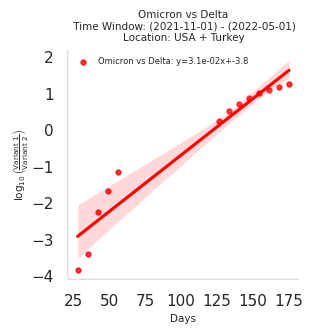

In [171]:
scatterplot('USA', 'Turkey', 1, 1, df_weekly_sum, '2021-11-01', '2022-05-01', 'Delta')

['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
Slove value: [('USA + Turkey', 0.02686843713571809)]
r-squared value: 0.9034576519016805
p_value value: 6.395450642117807e-07


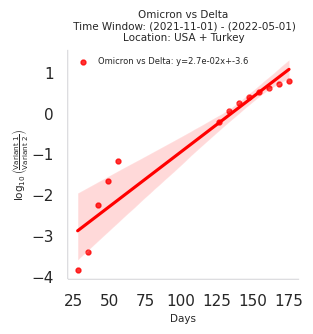

In [172]:
scatterplot('USA', 'Turkey', 0.25, 0.75, df_weekly_sum, '2021-11-01', '2022-05-01', 'Delta')

['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
Slove value: [('USA + Turkey', 0.034923372955707514)]
r-squared value: 0.9446142454583845
p_value value: 2.954666771636538e-08


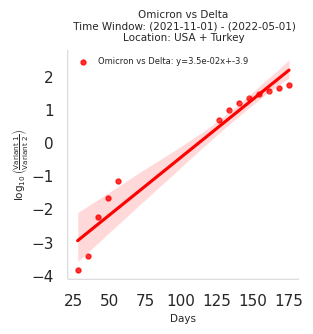

In [173]:
scatterplot('USA', 'Turkey', 0.75, 0.25, df_weekly_sum, '2021-11-01', '2022-05-01', 'Delta')

['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
Slove value: [('USA + Turkey', 0.02295854945698987)]
r-squared value: 0.8639691910740103
p_value value: 4.295473257891346e-06


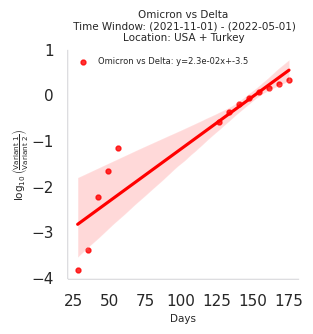

In [174]:
scatterplot('USA', 'Turkey', 0.1, 0.9, df_weekly_sum, '2021-11-01', '2022-05-01', 'Delta')

In [175]:
def transform_ratio(clade_1, clade_2):
    if clade_2 == 0 or np.isnan(clade_2):
        return np.nan  # Return NaN when denominator is zero or NaN
    else:
        return np.log10(clade_1 / clade_2)

In [176]:
# def scatterplot_with_mixing(dataset, country1, country2, start, end, variant):
#     # Mixing proportions, including controls
#     proportions = [(0, 1), (0.25, 0.75), (0.5, 0.5), (0.75, 0.25), (1, 0)]

#     # Define stable colors for each proportion
#     color_palette = ['blue', 'green', 'orange', 'purple', 'red']

#     slope_values = []  # To store DPGR slope values for each mix
#     plt.figure(figsize=(8, 6))

#     for idx, (prop1, prop2) in enumerate(proportions):
#         # Combine data for the given mixing proportions
#         combined_df = mix_locations(dataset, country1, country2, prop1, prop2)

#         # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
#         filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]

#         # Pivot dataframe to have variants as columns
#         df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq').reset_index()

#         # Specify time frame to analyze
#         df_sum = time_frame(df_weekly, start, end)

#         # Calculate log comparisons for the specified variants
#         df_ = clade_comparisons(df_sum)
#         df_['days'] -= df_['days'].iloc[0]

#         # Calculate slope for Omicron vs Delta
#         mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs Delta'])
#         slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs Delta'][mask])

#         # Store slope values for this mix
#         slope_values.append((f"{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}", slope))

#         # Plot the regression line with stable colors
#         sns.regplot(
#             x=df_['days'],
#             y=df_['Omicron vs Delta'],
#             scatter_kws={'s': 50},
#             label=f'{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}: slope={slope:.6f}',
#             color=color_palette[idx]
#         )

#     plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
#     plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Omicron}}{\mathrm{Delta}}\right)$', fontsize=10)
#     plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nMixing: {country1} + {country2}', fontsize=10)
#     plt.xlabel('Days', fontsize=10)
#     plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
#     plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
#     plt.gca().set_facecolor('white')
#     plt.show()

#     # Display slope values
#     slope_df = pd.DataFrame(slope_values, columns=['Mixing Proportion', 'Slope'])
#     print("DPGR Slope for Turkey and USA Mixing:")
#     print(slope_df)
#     return slope_df


In [206]:
def scatterplot_with_mixing(dataset, country1, country2, start, end, variant):
    # Mixing proportions, including controls
    proportions = [(0, 1), (0.25, 0.75), (0.5, 0.5), (0.75, 0.25), (1, 0)]

    # Define stable colors and marker styles for each proportion
    color_palette = ['blue', 'green', 'orange', 'purple', 'red']
    marker_styles = ['*', '+', 'o', 'v', '^']  # Different marker styles for each combination

    result_values = []  # To store DPGR slope, p-value, and R² for each mix
    plt.figure(figsize=(8, 6))  # Adjusted figure size

    for idx, (prop1, prop2) in enumerate(proportions):
        # Combine data for the given mixing proportions
        combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
        # print(combined_df)

        # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
        filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]

        # Pivot dataframe to have variants as columns
        df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq').reset_index()

        # Specify time frame to analyze
        df_sum = time_frame(df_weekly, start, end)

        # Calculate log comparisons for the specified variants
        df_ = clade_comparisons(df_sum)
        df_['days'] -= df_['days'].iloc[0]

        # Calculate slope for Omicron vs Delta
        mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs Delta'])
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs Delta'][mask])

        # Calculate R² (coefficient of determination)
        r_squared = r_value ** 2

        # Store results for this mix
        result_values.append({
            "Mixing Proportion": f"{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}",
            "Slope": slope,
            "P-value": p_value,
            "R²": r_squared
        })

        # Plot the regression line and scatter points with different marker styles
        sns.regplot(
            x=df_['days'],
            y=df_['Omicron vs Delta'],
            scatter_kws={'alpha': 0.7},  # Transparency for scatter points
            marker=marker_styles[idx],  # Different marker style for each combination
            label=f'{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}: slope={slope:.6f}',
            color=color_palette[idx]
        )

    # Add legend and axis labels
    plt.legend(loc='upper left', prop={'size': 8}, facecolor='white', frameon=False)
    plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Omicron}}{\mathrm{Delta}}\right)$', fontsize=10)
    plt.title(f'Omicron vs Delta\n Time Window: ({start}) - ({end})\nMixing: {country1} + {country2}', fontsize=12)
    plt.xlabel('Days', fontsize=10)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('white')
    plt.show()

    # Display slope values, p-values, and R²
    result_df = pd.DataFrame(result_values)
    result_df.to_csv('mix_prop_result.csv', index=False)
    print("DPGR Slope, P-value, and R² for Turkey and USA Mixing:")
    print(result_df)
    return result_df


['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']


<ipython-input-175-abfcb1777308>:5: RuntimeWarning: divide by zero encountered in log10
  return np.log10(clade_1 / clade_2)
<ipython-input-175-abfcb1777308>:5: RuntimeWarning: divide by zero encountered in log10
  return np.log10(clade_1 / clade_2)


['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']
['2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']


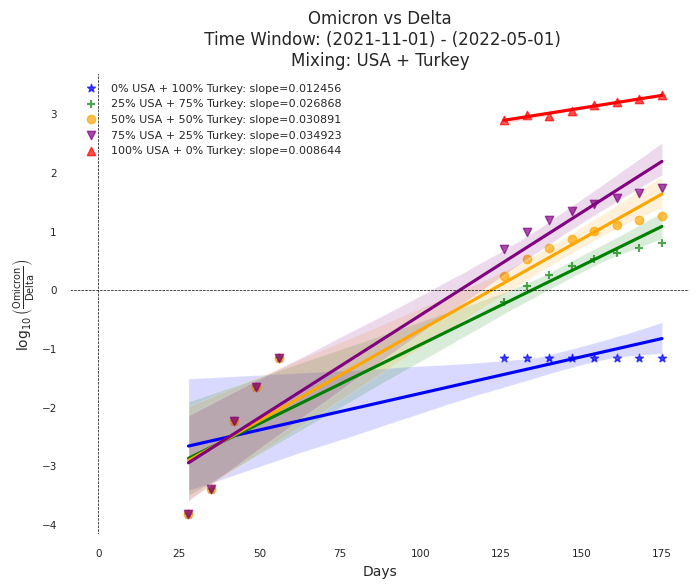

DPGR Slope, P-value, and R² for Turkey and USA Mixing:
      Mixing Proportion     Slope       P-value        R²
0  0% USA + 100% Turkey  0.012456  2.399731e-03  0.582595
1  25% USA + 75% Turkey  0.026868  6.395451e-07  0.903458
2  50% USA + 50% Turkey  0.030891  1.182354e-07  0.928823
3  75% USA + 25% Turkey  0.034923  2.954667e-08  0.944614
4  100% USA + 0% Turkey  0.008644  2.613431e-06  0.979754


,Mixing Proportion,Slope,P-value,R²
0,0% USA + 100% Turkey,0.012456,2.399731e-03,0.582595
1,25% USA + 75% Turkey,0.026868,6.395451e-07,0.903458
2,50% USA + 50% Turkey,0.030891,1.182354e-07,0.928823
3,75% USA + 25% Turkey,0.034923,2.954667e-08,0.944614
4,100% USA + 0% Turkey,0.008644,2.613431e-06,0.979754


In [207]:
scatterplot_with_mixing(df_weekly_sum, 'USA', 'Turkey', '2021-11-01', '2022-05-01', 'Delta')

In [185]:
def scatterplot_with_individual_plots(dataset, country1, country2, start, end, variant):
    # Mixing proportions, including controls
    proportions = [(0, 1), (0.25, 0.75), (0.5, 0.5), (0.75, 0.25), (1, 0)]

    # Define stable colors for each proportion
    color_palette = ['blue', 'green', 'orange', 'purple', 'red']

    result_values = []  # To store DPGR slope, p-value, and R² for each mix

    for idx, (prop1, prop2) in enumerate(proportions):
        # Combine data for the given mixing proportions
        combined_df = mix_locations(dataset, country1, country2, prop1, prop2)
        print(f"Data for {prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}")
        print(combined_df)

        # Filter to show only 'Delta' and 'Omicron' variants and select relevant columns
        filtered_df = combined_df[combined_df['Variant'].isin(['Delta', 'Omicron'])][['Variant', 'Date', 'Freq']]

        # Pivot dataframe to have variants as columns
        df_weekly = combined_df.pivot(index='Date', columns='Variant', values='Freq').reset_index()

        # Specify time frame to analyze
        df_sum = time_frame(df_weekly, start, end)

        # Calculate log comparisons for the specified variants
        df_ = clade_comparisons(df_sum)
        df_['days'] -= df_['days'].iloc[0]

        # Calculate slope for Omicron vs Delta
        mask = ~np.isnan(df_['days']) & ~np.isnan(df_['Omicron vs Delta'])
        if not mask.any():
            print(f"No valid data for {prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}")
            continue
        slope, intercept, r_value, p_value, std_err = stats.linregress(df_['days'][mask], df_['Omicron vs Delta'][mask])

        # Calculate R² (coefficient of determination)
        r_squared = r_value ** 2

        # Store results for this mix
        result_values.append({
            "Mixing Proportion": f"{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}",
            "Slope": slope,
            "P-value": p_value,
            "R²": r_squared
        })

        # Plot individual regression line
        plt.figure(figsize=(8, 6))
        sns.regplot(
            x=df_['days'],
            y=df_['Omicron vs Delta'],
            scatter_kws={'s': 50},
            label=f'{prop1 * 100:.0f}% {country1} + {prop2 * 100:.0f}% {country2}: slope={slope:.6f}',
            color=color_palette[idx]
        )
        plt.legend(loc='upper left', prop={'size': 6}, facecolor='white', frameon=False)
        plt.ylabel(r'$\log_{10}\left(\frac{\mathrm{Omicron}}{\mathrm{Delta}}\right)$', fontsize=10)
        plt.title(f'Omicron vs Delta\nTime Window: ({start}) - ({end})\nMixing: {country1} + {country2}', fontsize=10)
        plt.xlabel('Days', fontsize=10)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
        plt.gca().set_facecolor('white')

        # Save the plot for individual combinations
        plt.savefig(f"{prop1 * 100:.0f}_{country1}_{prop2 * 100:.0f}_{country2}_mixing.png")
        plt.show()

    # Display slope values, p-values, and R²
    result_df = pd.DataFrame(result_values)
    print("DPGR Slope, P-value, and R² for Turkey and USA Mixing:")
    print(result_df)
    return result_df


Data for 0% USA + 100% Turkey
    Variant       Date Location  Freq
0     Alpha 2022-03-07      USA     0
1     Alpha 2022-03-14      USA     0
2     Alpha 2022-04-25      USA     0
3     Delta 2021-11-01   Turkey  1346
4     Delta 2021-11-08   Turkey  1080
5     Delta 2021-11-15   Turkey  1251
6     Delta 2021-11-22   Turkey  1130
7     Delta 2021-11-29   Turkey  1907
8     Delta 2021-12-06   Turkey   902
9     Delta 2021-12-13   Turkey   867
10    Delta 2021-12-20   Turkey  1028
11    Delta 2021-12-27   Turkey  1095
12    Delta 2022-03-07      USA     0
13    Delta 2022-03-14      USA     0
14    Delta 2022-03-21      USA     0
15    Delta 2022-03-28      USA     0
16    Delta 2022-04-04      USA     0
17    Delta 2022-04-11      USA     0
18    Delta 2022-04-18      USA     0
19    Delta 2022-04-25      USA     0
20  Omicron 2021-11-29   Turkey     1
21  Omicron 2021-12-06   Turkey     2
22  Omicron 2021-12-13   Turkey    46
23  Omicron 2021-12-20   Turkey   159
24  Omicron 2021-12-

<ipython-input-175-abfcb1777308>:5: RuntimeWarning: divide by zero encountered in log10
  return np.log10(clade_1 / clade_2)
<ipython-input-175-abfcb1777308>:5: RuntimeWarning: divide by zero encountered in log10
  return np.log10(clade_1 / clade_2)


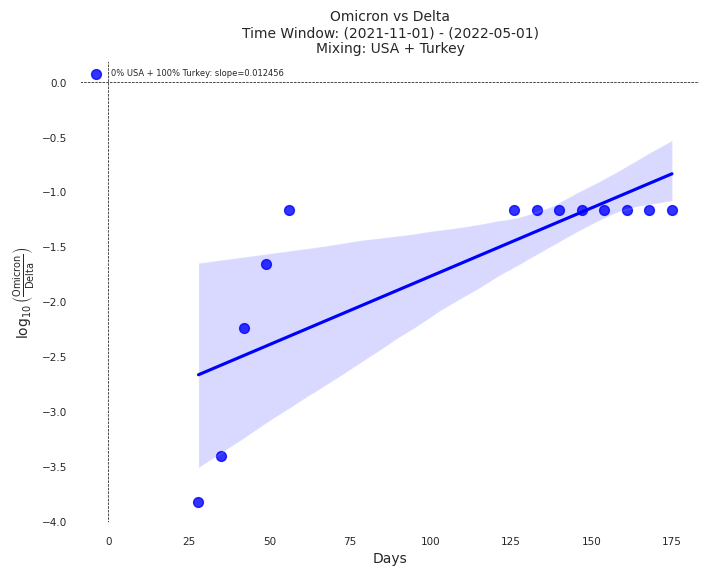

Data for 25% USA + 75% Turkey
    Variant       Date Location     Freq
0     Alpha 2022-03-07      USA     0.25
1     Alpha 2022-03-14      USA     0.25
2     Alpha 2022-04-25      USA     0.25
3     Delta 2021-11-01   Turkey  1009.50
4     Delta 2021-11-08   Turkey   810.00
5     Delta 2021-11-15   Turkey   938.25
6     Delta 2021-11-22   Turkey   847.50
7     Delta 2021-11-29   Turkey  1430.25
8     Delta 2021-12-06   Turkey   676.50
9     Delta 2021-12-13   Turkey   650.25
10    Delta 2021-12-20   Turkey   771.00
11    Delta 2021-12-27   Turkey   821.25
12    Delta 2022-03-07      USA     5.50
13    Delta 2022-03-14      USA     3.75
14    Delta 2022-03-21      USA     5.50
15    Delta 2022-03-28      USA     2.50
16    Delta 2022-04-04      USA     1.75
17    Delta 2022-04-11      USA     2.50
18    Delta 2022-04-18      USA     1.25
19    Delta 2022-04-25      USA     0.75
20  Omicron 2021-11-29   Turkey     0.75
21  Omicron 2021-12-06   Turkey     1.50
22  Omicron 2021-12-13   Tu

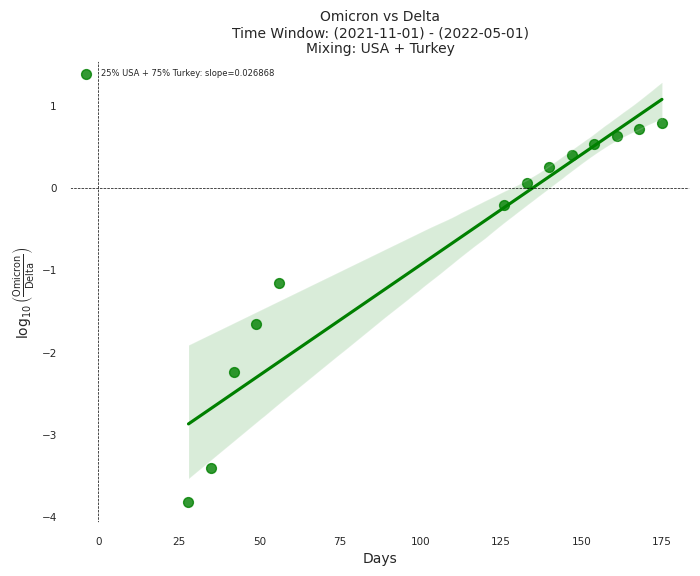

Data for 50% USA + 50% Turkey
    Variant       Date Location     Freq
0     Alpha 2022-03-07      USA      0.5
1     Alpha 2022-03-14      USA      0.5
2     Alpha 2022-04-25      USA      0.5
3     Delta 2021-11-01   Turkey    673.0
4     Delta 2021-11-08   Turkey    540.0
5     Delta 2021-11-15   Turkey    625.5
6     Delta 2021-11-22   Turkey    565.0
7     Delta 2021-11-29   Turkey    953.5
8     Delta 2021-12-06   Turkey    451.0
9     Delta 2021-12-13   Turkey    433.5
10    Delta 2021-12-20   Turkey    514.0
11    Delta 2021-12-27   Turkey    547.5
12    Delta 2022-03-07      USA     11.0
13    Delta 2022-03-14      USA      7.5
14    Delta 2022-03-21      USA     11.0
15    Delta 2022-03-28      USA      5.0
16    Delta 2022-04-04      USA      3.5
17    Delta 2022-04-11      USA      5.0
18    Delta 2022-04-18      USA      2.5
19    Delta 2022-04-25      USA      1.5
20  Omicron 2021-11-29   Turkey      0.5
21  Omicron 2021-12-06   Turkey      1.0
22  Omicron 2021-12-13   Tu

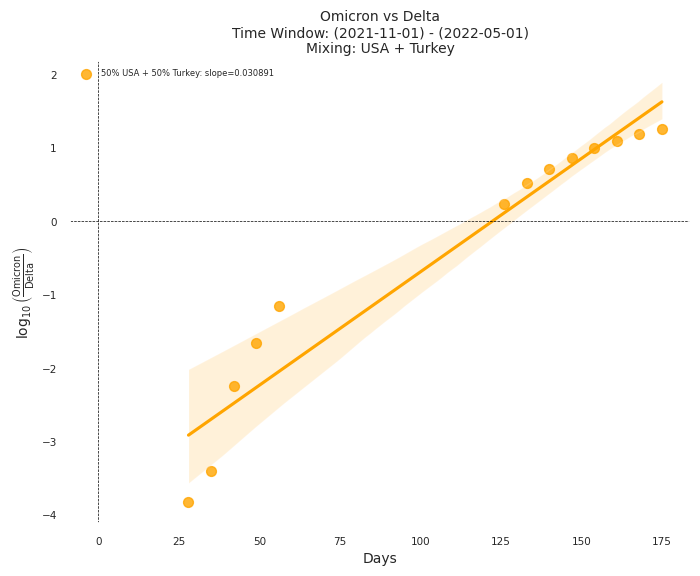

Data for 75% USA + 25% Turkey
    Variant       Date Location      Freq
0     Alpha 2022-03-07      USA      0.75
1     Alpha 2022-03-14      USA      0.75
2     Alpha 2022-04-25      USA      0.75
3     Delta 2021-11-01   Turkey    336.50
4     Delta 2021-11-08   Turkey    270.00
5     Delta 2021-11-15   Turkey    312.75
6     Delta 2021-11-22   Turkey    282.50
7     Delta 2021-11-29   Turkey    476.75
8     Delta 2021-12-06   Turkey    225.50
9     Delta 2021-12-13   Turkey    216.75
10    Delta 2021-12-20   Turkey    257.00
11    Delta 2021-12-27   Turkey    273.75
12    Delta 2022-03-07      USA     16.50
13    Delta 2022-03-14      USA     11.25
14    Delta 2022-03-21      USA     16.50
15    Delta 2022-03-28      USA      7.50
16    Delta 2022-04-04      USA      5.25
17    Delta 2022-04-11      USA      7.50
18    Delta 2022-04-18      USA      3.75
19    Delta 2022-04-25      USA      2.25
20  Omicron 2021-11-29   Turkey      0.25
21  Omicron 2021-12-06   Turkey      0.50
22  

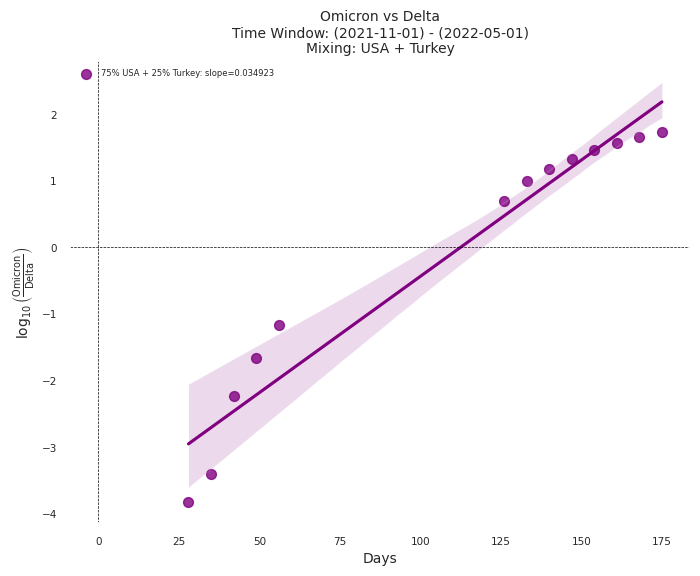

Data for 100% USA + 0% Turkey
    Variant       Date Location   Freq
0     Alpha 2022-03-07      USA      1
1     Alpha 2022-03-14      USA      1
2     Alpha 2022-04-25      USA      1
3     Delta 2021-11-01   Turkey      0
4     Delta 2021-11-08   Turkey      0
5     Delta 2021-11-15   Turkey      0
6     Delta 2021-11-22   Turkey      0
7     Delta 2021-11-29   Turkey      0
8     Delta 2021-12-06   Turkey      0
9     Delta 2021-12-13   Turkey      0
10    Delta 2021-12-20   Turkey      0
11    Delta 2021-12-27   Turkey      0
12    Delta 2022-03-07      USA     22
13    Delta 2022-03-14      USA     15
14    Delta 2022-03-21      USA     22
15    Delta 2022-03-28      USA     10
16    Delta 2022-04-04      USA      7
17    Delta 2022-04-11      USA     10
18    Delta 2022-04-18      USA      5
19    Delta 2022-04-25      USA      3
20  Omicron 2021-11-29   Turkey      0
21  Omicron 2021-12-06   Turkey      0
22  Omicron 2021-12-13   Turkey      0
23  Omicron 2021-12-20   Turkey   

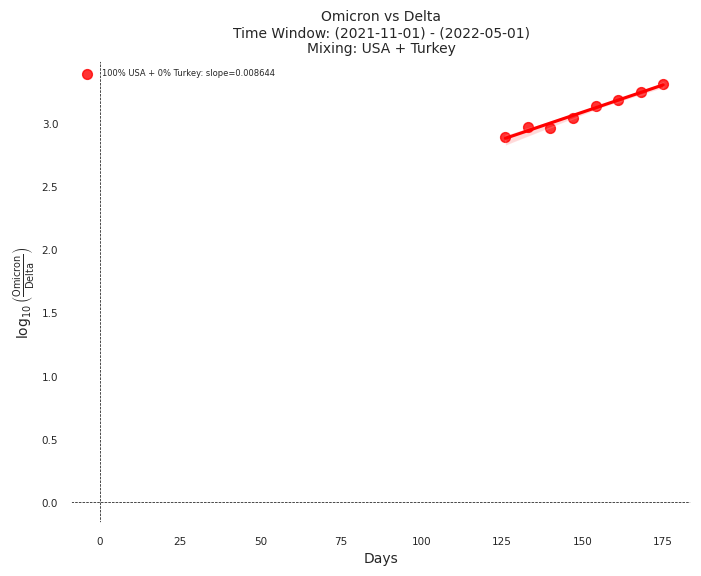

DPGR Slope, P-value, and R² for Turkey and USA Mixing:
      Mixing Proportion     Slope       P-value        R²
0  0% USA + 100% Turkey  0.012456  2.399731e-03  0.582595
1  25% USA + 75% Turkey  0.026868  6.395451e-07  0.903458
2  50% USA + 50% Turkey  0.030891  1.182354e-07  0.928823
3  75% USA + 25% Turkey  0.034923  2.954667e-08  0.944614
4  100% USA + 0% Turkey  0.008644  2.613431e-06  0.979754


,Mixing Proportion,Slope,P-value,R²
0,0% USA + 100% Turkey,0.012456,2.399731e-03,0.582595
1,25% USA + 75% Turkey,0.026868,6.395451e-07,0.903458
2,50% USA + 50% Turkey,0.030891,1.182354e-07,0.928823
3,75% USA + 25% Turkey,0.034923,2.954667e-08,0.944614
4,100% USA + 0% Turkey,0.008644,2.613431e-06,0.979754


In [186]:
scatterplot_with_individual_plots(df_weekly_sum, 'USA', 'Turkey', '2021-11-01', '2022-05-01', 'Delta')
